In this notebook, I will be implementing a series of models on feature-engineered data.

__1. Packages__

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display

In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [4]:
from tabulate import tabulate

In [5]:
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

__2. Data__

In [6]:
tr_fea_df = pd.read_csv(filepath_or_buffer='./data/train_fea.csv')
cv_fea_df = pd.read_csv(filepath_or_buffer='./data/cv_fea.csv')
te_fea_df = pd.read_csv(filepath_or_buffer='./data/test_fea.csv')

In [7]:
fea_cols = list(tr_fea_df.columns)
target = fea_cols.pop()
print(fea_cols)
print(target)

['u', 'g', 'r', 'redshift', 'g-r', 'i-z', 'u-r', 'i-r', 'z-r']
class


In [8]:
labels = cv_fea_df['class'].unique()
print(labels)

['GALAXY' 'QSO' 'STAR']


In [9]:
X_train = tr_fea_df[fea_cols].values
y_train = tr_fea_df[target].values

In [10]:
X_cv = cv_fea_df[fea_cols].values
y_cv = cv_fea_df[target].values

In [11]:
X_test = te_fea_df[fea_cols].values
y_test = te_fea_df[target].values

In [12]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(63999, 9) (63999,)
(16000, 9) (16000,)
(20000, 9) (20000,)


__3. Confusion, Precision, and Recall matrices__

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    
    Parameters
    ----------
    `matrix`: 2D array
    `title`: title
    `labels`: target values
    
    Returns none.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_pred`: predicted values
    `labels`: target values
    
    Returns none.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

In [17]:
def reporter(clf, X, y, title, labels, best=None):
    """
    This functions generates the report.
    
    Parameters
    ----------
    `clf`: classifier object
    `X`: features
    `y`: target
    `title`: title of the report
    `labels`: target values
    `best`: best parameters which are learned
    
    Returns logloss.
    """
    pred = clf.predict_proba(X=X)
    
    loss = log_loss(y_true=y, y_pred=pred)
    loss = np.round(a=loss, decimals=3)
    
    cm_pred = clf.predict(X=X)
    
    print(title)
    if best is None:
        print("Logloss: {}".format(loss))
    else:
        print("Logloss: {}".format(loss))
        print("Best parameters: {}".format(best))
    
    plot_confusion_matrix(y_true=y, y_pred=cm_pred, labels=labels)
    
    print(classification_report(y_true=y, y_pred=cm_pred))
    
    return loss

__4. Modeling__

4.1. RandomizedSearchCV for hyperparameter tuning

In [18]:
from sklearn.model_selection import RandomizedSearchCV

In [19]:
def tuner(clf, dist, X, y):
    """
    This function tunes the hyperparameters.
    
    Parameters
    ----------
    `clf`: estimator object
    `dist`: hyperparameters to be tuned
    `X`: features
    `y`: target
    
    Returns the best values for hyperparameters.
    """
    rs_clf = RandomizedSearchCV(estimator=clf, random_state=0, n_jobs=-1,
                                param_distributions=dist)
    search = rs_clf.fit(X=X, y=y)
    return search.best_params_

4.2. Models

In [20]:
def get_model_path(model_name):
    """
    This function gets the model path.
    
    Parameter
    ---------
    `model_name`: name of the model
    
    Returns path of the model.
    """
    if os.path.isdir('./model_dumps'):
        pass
    else:
        os.mkdir(path='./model_dumps')
    
    model_path = os.path.join('./model_dumps', model_name)
    return model_path

4.2.1. Random or dummy model

The purpose of building a random or a dummy classifier is, the output of a multi-class logloss function is bounded between $0$ and $\infty$. Hence I will be using a dummy classifier to benchmark the performance of the worst model. Any real model that I will build should perform better than a random or a dummy classifier.

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
def dummy_classifier(X_train,
                     y_train,
                     X_cv,
                     y_cv,
                     X_test,
                     y_test,
                     model_name,
                     labels=labels):
    """
    A random or dummy model.
    """
    model_path = get_model_path(model_name=model_name)
    
    if not os.path.isfile(path=model_path):
        clf = DummyClassifier(strategy='uniform')
        clf.fit(X=X_train, y=y_train)
        
        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=clf, file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=clf, X=X_train, y=y_train,
                       title='Train', labels=labels)
    cv_loss = reporter(clf=clf, X=X_cv, y=y_cv,
                       title='Cross Validation', labels=labels)
    te_loss = reporter(clf=clf, X=X_test, y=y_test,
                       title='Test', labels=labels)
    
    return tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 1.099
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


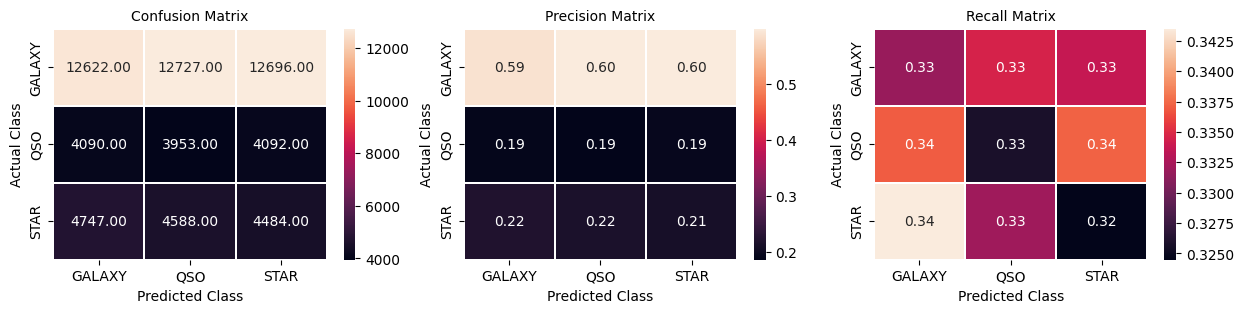

              precision    recall  f1-score   support

      GALAXY       0.59      0.33      0.42     38045
         QSO       0.19      0.33      0.24     12135
        STAR       0.21      0.32      0.26     13819

    accuracy                           0.33     63999
   macro avg       0.33      0.33      0.31     63999
weighted avg       0.43      0.33      0.35     63999

Cross Validation
Logloss: 1.099
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


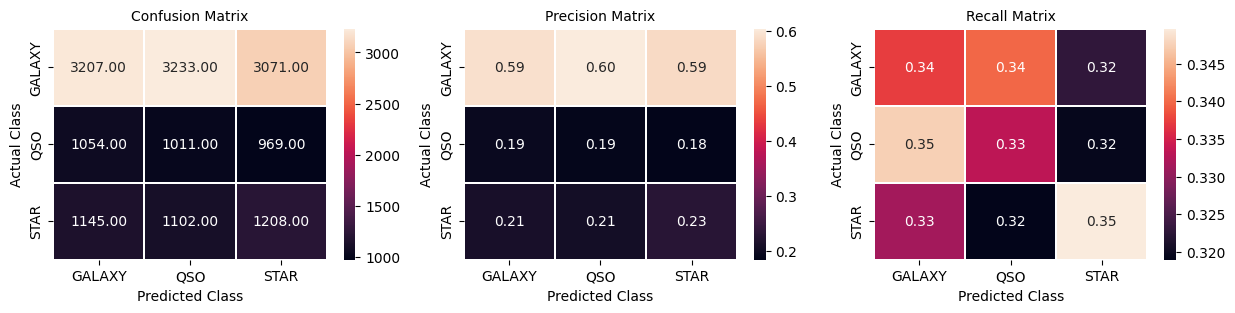

              precision    recall  f1-score   support

      GALAXY       0.59      0.34      0.43      9511
         QSO       0.19      0.33      0.24      3034
        STAR       0.23      0.35      0.28      3455

    accuracy                           0.34     16000
   macro avg       0.34      0.34      0.32     16000
weighted avg       0.44      0.34      0.36     16000

Test
Logloss: 1.099
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


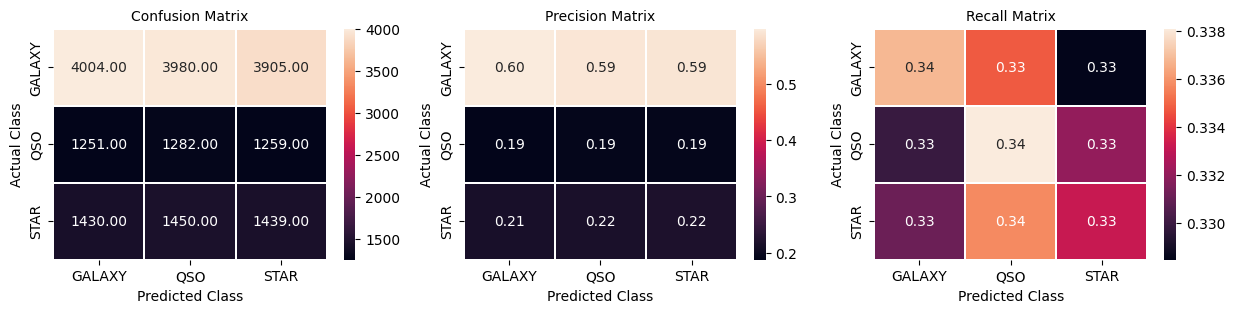

              precision    recall  f1-score   support

      GALAXY       0.60      0.34      0.43     11889
         QSO       0.19      0.34      0.24      3792
        STAR       0.22      0.33      0.26      4319

    accuracy                           0.34     20000
   macro avg       0.34      0.34      0.31     20000
weighted avg       0.44      0.34      0.36     20000



In [23]:
model_name = 'model_dummy_classifier.pkl'

(dummy_tr_loss,
 dummy_cv_loss,
 dummy_te_loss) = dummy_classifier(X_train=X_train,
                                   y_train=y_train,
                                   X_cv=X_cv,
                                   y_cv=y_cv,
                                   X_test=X_test,
                                   y_test=y_test,
                                   model_name=model_name)

4.2.2. Logistic regression

In [24]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

In [25]:
def logistic_regresson(X_train,
                       y_train,
                       X_cv,
                       y_cv,
                       X_test,
                       y_test,
                       dist,
                       model_name,
                       labels=labels):
    """
    This function builds the logistic regression model.
    """
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = LogisticRegression(n_jobs=-1, random_state=42, max_iter=1000, 
                                 class_weight='balanced')

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = LogisticRegression(n_jobs=-1, max_iter=1000, C=best['C'],
                                 random_state=42, penalty=best['penalty'],
                                 class_weight='balanced')
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 0.322
Best parameters: {'penalty': 'l2', 'C': 10}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


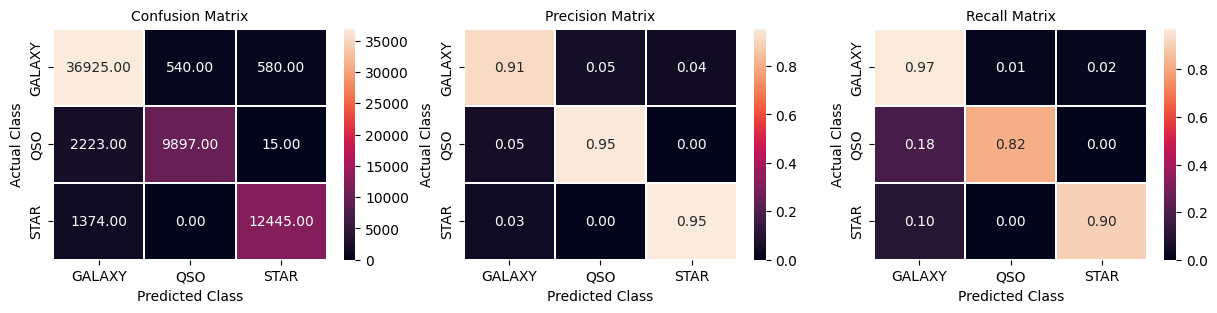

              precision    recall  f1-score   support

      GALAXY       0.91      0.97      0.94     38045
         QSO       0.95      0.82      0.88     12135
        STAR       0.95      0.90      0.93     13819

    accuracy                           0.93     63999
   macro avg       0.94      0.90      0.91     63999
weighted avg       0.93      0.93      0.93     63999

Cross Validation
Logloss: 0.32
Best parameters: {'penalty': 'l2', 'C': 10}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


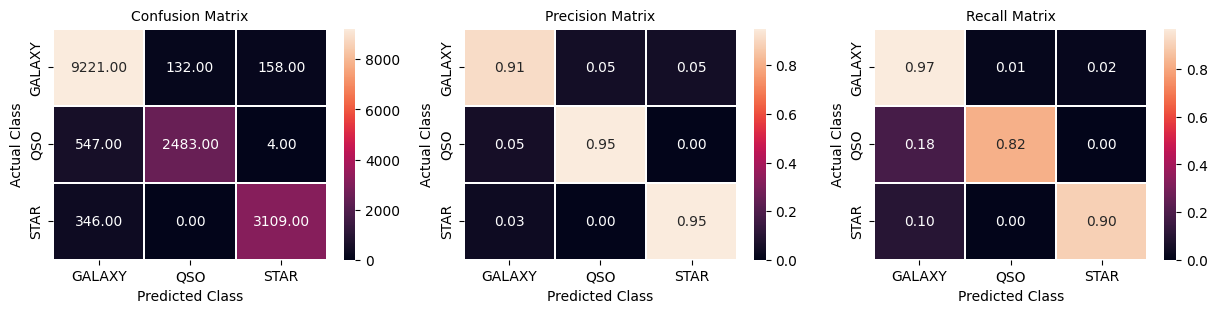

              precision    recall  f1-score   support

      GALAXY       0.91      0.97      0.94      9511
         QSO       0.95      0.82      0.88      3034
        STAR       0.95      0.90      0.92      3455

    accuracy                           0.93     16000
   macro avg       0.94      0.90      0.91     16000
weighted avg       0.93      0.93      0.92     16000

Test
Logloss: 0.324
Best parameters: {'penalty': 'l2', 'C': 10}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


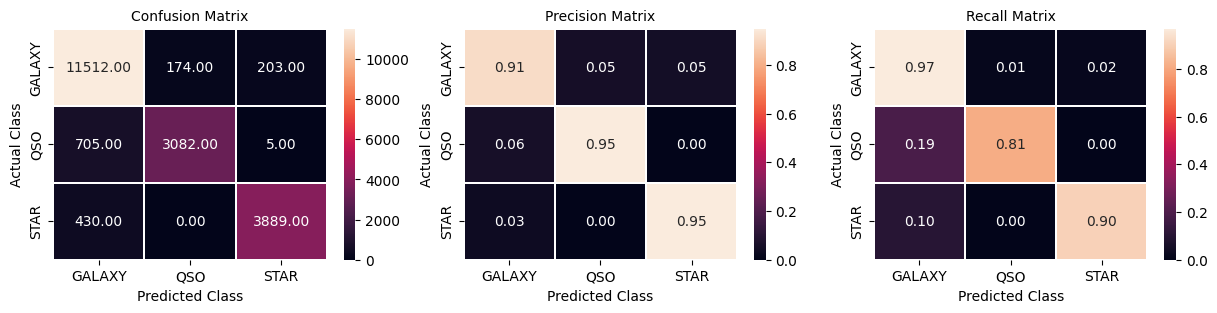

              precision    recall  f1-score   support

      GALAXY       0.91      0.97      0.94     11889
         QSO       0.95      0.81      0.87      3792
        STAR       0.95      0.90      0.92      4319

    accuracy                           0.92     20000
   macro avg       0.94      0.89      0.91     20000
weighted avg       0.93      0.92      0.92     20000



In [26]:
model_name = 'model_logistic_regression.pkl'

dist = dict(C=[10 ** x for x in range(-4, 3)], penalty=['l2', 'l1'])

(logreg_best,
 logreg_tr_loss,
 logreg_cv_loss,
 logreg_te_loss) = logistic_regresson(X_train=X_train,
                                      y_train=y_train,
                                      X_cv=X_cv,
                                      y_cv=y_cv,
                                      X_test=X_test,
                                      y_test=y_test,
                                      dist=dist,
                                      model_name=model_name)

4.2.3. Support vector classifier

In [27]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [28]:
def support_vector_classifier(X_train,
                              y_train,
                              X_cv,
                              y_cv,
                              X_test,
                              y_test,
                              dist,
                              model_name,
                              labels=labels):
    """
    This function builds the support vector classifier model.
    """
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = SVC(random_state=42, class_weight='balanced')

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = SVC(C=best['C'], random_state=42, class_weight='balanced')
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 0.137
Best parameters: {'C': 100}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


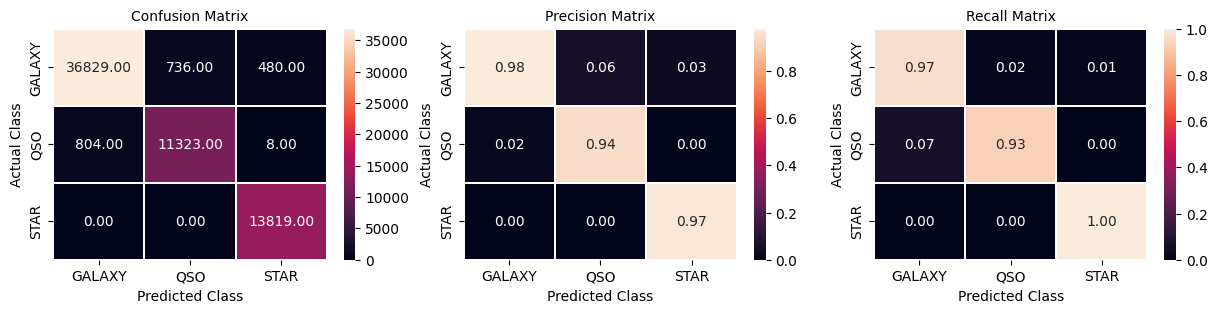

              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97     38045
         QSO       0.94      0.93      0.94     12135
        STAR       0.97      1.00      0.98     13819

    accuracy                           0.97     63999
   macro avg       0.96      0.97      0.96     63999
weighted avg       0.97      0.97      0.97     63999

Cross Validation
Logloss: 0.134
Best parameters: {'C': 100}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


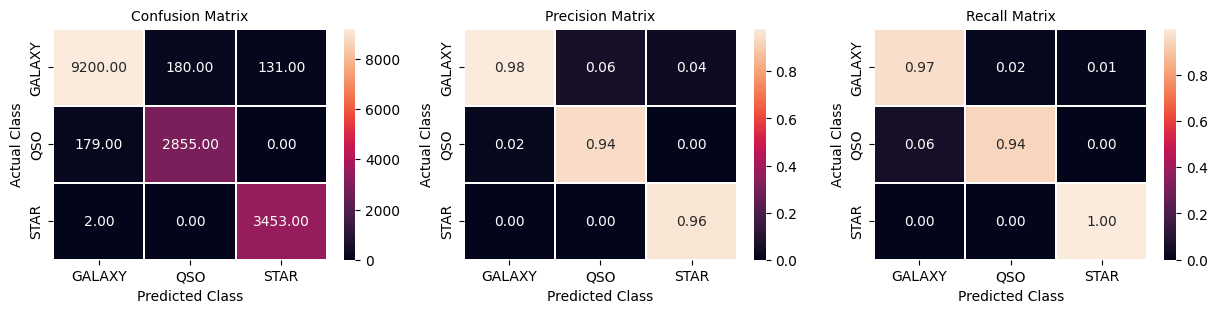

              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97      9511
         QSO       0.94      0.94      0.94      3034
        STAR       0.96      1.00      0.98      3455

    accuracy                           0.97     16000
   macro avg       0.96      0.97      0.97     16000
weighted avg       0.97      0.97      0.97     16000

Test
Logloss: 0.146
Best parameters: {'C': 100}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


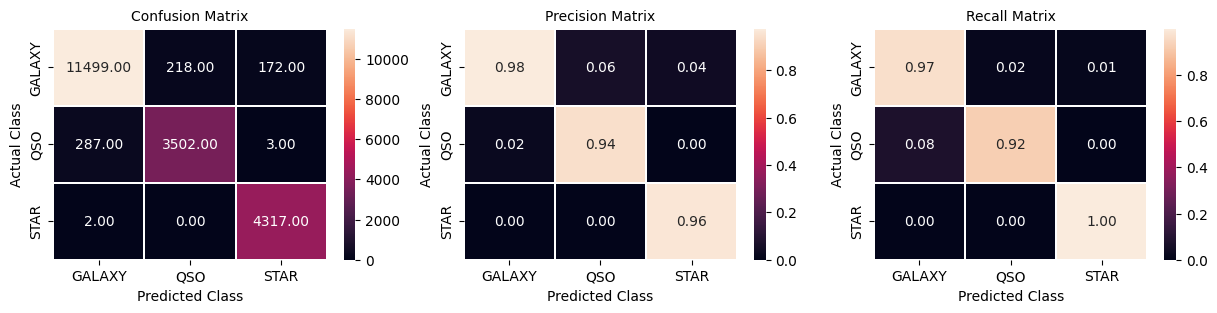

              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97     11889
         QSO       0.94      0.92      0.93      3792
        STAR       0.96      1.00      0.98      4319

    accuracy                           0.97     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000



In [29]:
model_name = 'model_support_vector_classifier.pkl'

dist = dict(C=[10 ** x for x in range(-4, 3)])

(svc_best,
 svc_tr_loss,
 svc_cv_loss,
 svc_te_loss) = support_vector_classifier(X_train=X_train,
                                          y_train=y_train,
                                          X_cv=X_cv,
                                          y_cv=y_cv,
                                          X_test=X_test,
                                          y_test=y_test,
                                          dist=dist,
                                          model_name=model_name)

4.2.4. K neighbors classifier

In [30]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

In [31]:
def k_neighbors_classifier(X_train,
                           y_train,
                           X_cv,
                           y_cv,
                           X_test,
                           y_test,
                           dist,
                           model_name,
                           labels=labels):
    """
    This function builds the k neighbors classifier.
    """
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = KNeighborsClassifier(n_jobs=-1)

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=best['n_neighbors'])
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 0.096
Best parameters: {'n_neighbors': 5}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


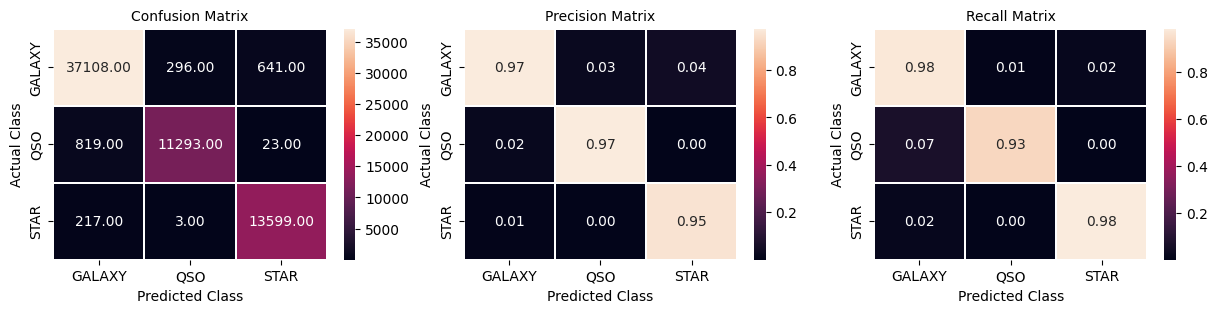

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     38045
         QSO       0.97      0.93      0.95     12135
        STAR       0.95      0.98      0.97     13819

    accuracy                           0.97     63999
   macro avg       0.97      0.96      0.96     63999
weighted avg       0.97      0.97      0.97     63999

Cross Validation
Logloss: 0.126
Best parameters: {'n_neighbors': 5}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


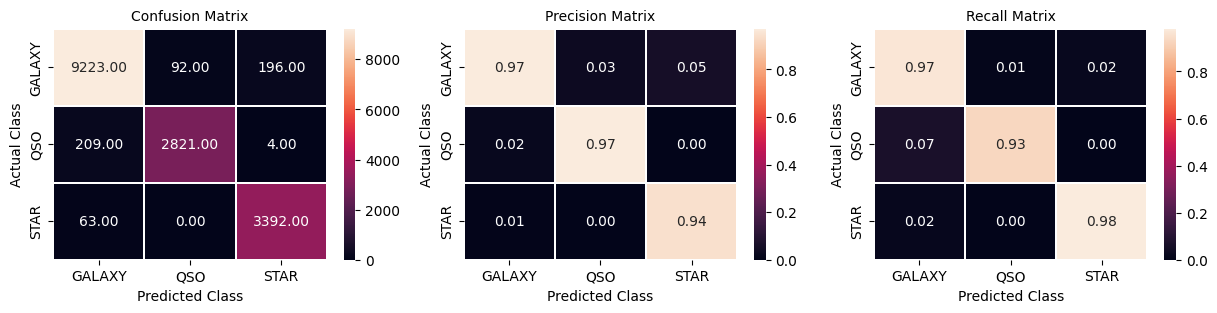

              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97      9511
         QSO       0.97      0.93      0.95      3034
        STAR       0.94      0.98      0.96      3455

    accuracy                           0.96     16000
   macro avg       0.96      0.96      0.96     16000
weighted avg       0.96      0.96      0.96     16000

Test
Logloss: 0.145
Best parameters: {'n_neighbors': 5}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


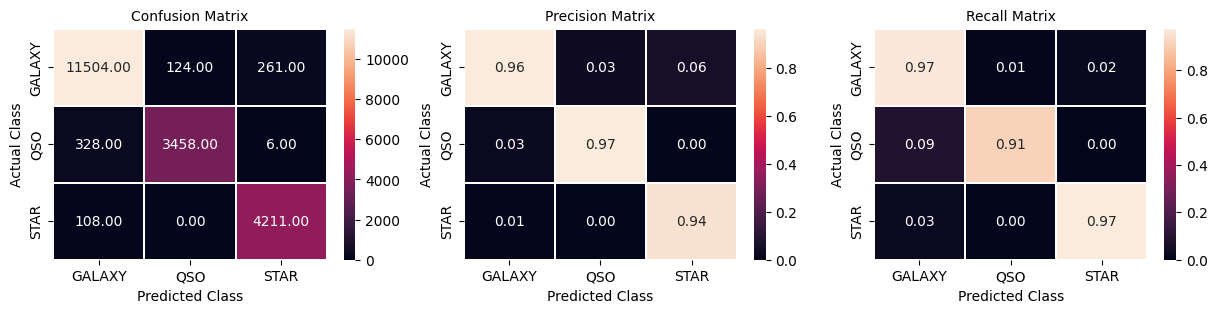

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     11889
         QSO       0.97      0.91      0.94      3792
        STAR       0.94      0.97      0.96      4319

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000



In [32]:
model_name = 'model_k_neighbors_classifier.pkl'

dist = dict(n_neighbors=[3, 5, 11, 15, 21, 31, 41, 51, 99])

(knn_best,
 knn_tr_loss,
 knn_cv_loss,
 knn_te_loss) = k_neighbors_classifier(X_train=X_train,
                                       y_train=y_train,
                                       X_cv=X_cv,
                                       y_cv=y_cv,
                                       X_test=X_test,
                                       y_test=y_test,
                                       dist=dist,
                                       model_name=model_name)

4.2.5. Decision tree classifier

In [33]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

In [34]:
def decision_tree_classifier(X_train,
                             y_train,
                             X_cv,
                             y_cv,
                             X_test,
                             y_test,
                             dist,
                             model_name,
                             labels=labels):
    """
    This function builds the decision tree classifier.
    """
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = DecisionTreeClassifier(random_state=42)

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = DecisionTreeClassifier(criterion=best['criterion'],
                                     max_depth=best['max_depth'],
                                     min_samples_split=best['min_samples_split'],
                                     random_state=42)
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 0.064
Best parameters: {'min_samples_split': 100, 'max_depth': 100, 'criterion': 'gini'}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


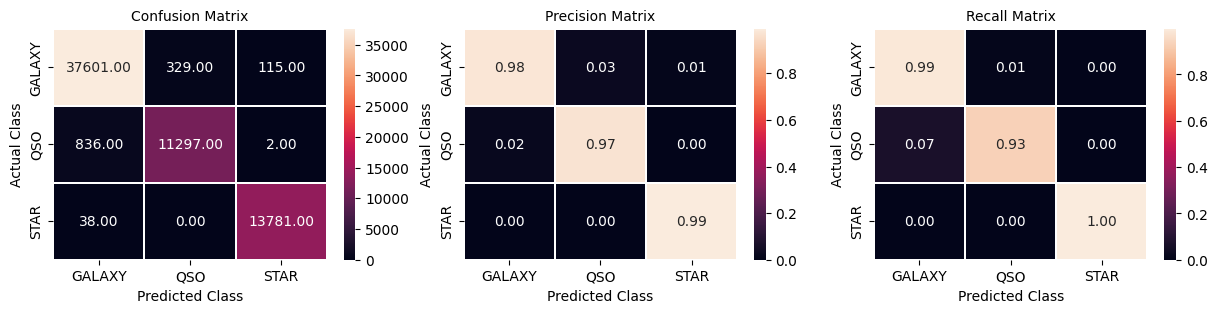

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     38045
         QSO       0.97      0.93      0.95     12135
        STAR       0.99      1.00      0.99     13819

    accuracy                           0.98     63999
   macro avg       0.98      0.97      0.98     63999
weighted avg       0.98      0.98      0.98     63999

Cross Validation
Logloss: 0.084
Best parameters: {'min_samples_split': 100, 'max_depth': 100, 'criterion': 'gini'}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


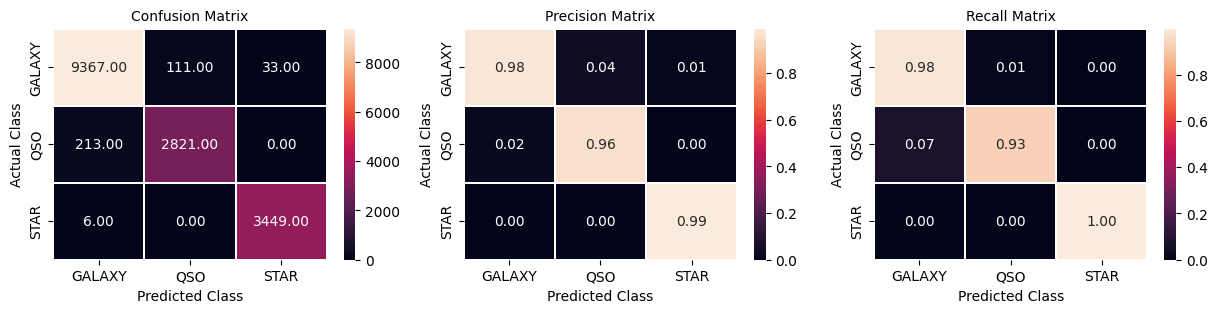

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      9511
         QSO       0.96      0.93      0.95      3034
        STAR       0.99      1.00      0.99      3455

    accuracy                           0.98     16000
   macro avg       0.98      0.97      0.97     16000
weighted avg       0.98      0.98      0.98     16000

Test
Logloss: 0.094
Best parameters: {'min_samples_split': 100, 'max_depth': 100, 'criterion': 'gini'}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


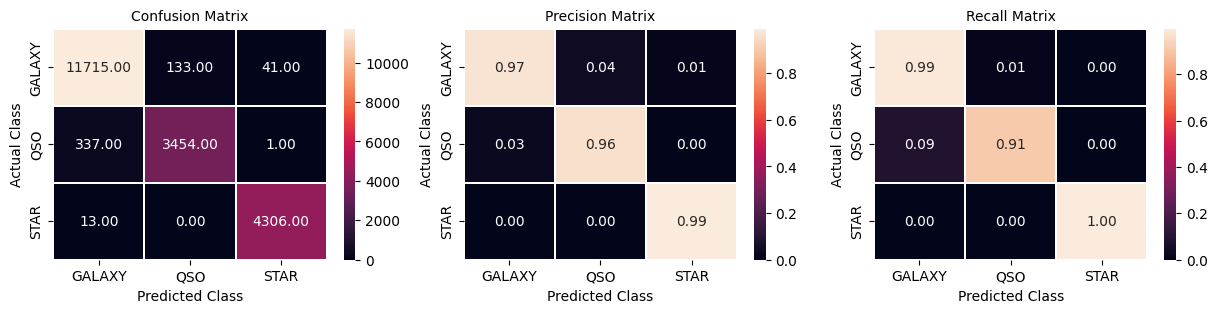

              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     11889
         QSO       0.96      0.91      0.94      3792
        STAR       0.99      1.00      0.99      4319

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [35]:
model_name = 'model_decision_tree_classifier.pkl'

dist = dict(criterion=['gini', 'entropy', 'log_loss'],
            max_depth=[1, 5, 10, 50, 100],
            min_samples_split=[5, 10, 100, 250, 500])

(dt_best,
 dt_tr_loss,
 dt_cv_loss,
 dt_te_loss) = decision_tree_classifier(X_train=X_train,
                                        y_train=y_train,
                                        X_cv=X_cv,
                                        y_cv=y_cv,
                                        X_test=X_test,
                                        y_test=y_test,
                                        dist=dist,
                                        model_name=model_name)

4.2.6. Random forest classifier

In [36]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [37]:
def feature_importance_plot(data, x, y, title):
    """
    This function plots the feature importance plot.
    
    Parameters
    ----------
    `data`: dataframe
    `x`: x-axis
    `y`: y-axis
    `title`: title of the plot
    
    Returns none.
    """
    bars = sns.barplot(data=data, x=x, y=y)
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = np.round(b.get_height(), 3)
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label=title)

In [38]:
def random_forest_classifier(X_train,
                             y_train,
                             X_cv,
                             y_cv,
                             X_test,
                             y_test,
                             dist,
                             model_name,
                             labels=labels,
                             plot_fi=False):
    """
    This function builds the random forest classifier.
    """
    model_path = get_model_path(model_name=model_name)

    if not os.path.isfile(path=model_path):
        clf = RandomForestClassifier(n_jobs=-1, random_state=42)

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = RandomForestClassifier(n_estimators=best['n_estimators'],
                                     criterion=best['criterion'],
                                     max_depth=best['max_depth'],
                                     min_samples_split=best['min_samples_split'],
                                     n_jobs=-1, random_state=42)
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    if plot_fi:
        imp_df = pd.DataFrame()
        imp_df['Features'] = fea_cols
        imp_df['Importance'] = clf.feature_importances_
        imp_df = imp_df.sort_values(by=['Importance'], ascending=False)
        imp_df['Cumulative'] = np.cumsum(a=imp_df['Importance'].values)
    
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        feature_importance_plot(data=imp_df, x='Features', y='Importance',
                                title='Feature Importace')
        plt.subplot(122)
        feature_importance_plot(data=imp_df, x='Features', y='Cumulative',
                                title='Cumulative Feature Importance')
        plt.show()
    else:
        pass
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.



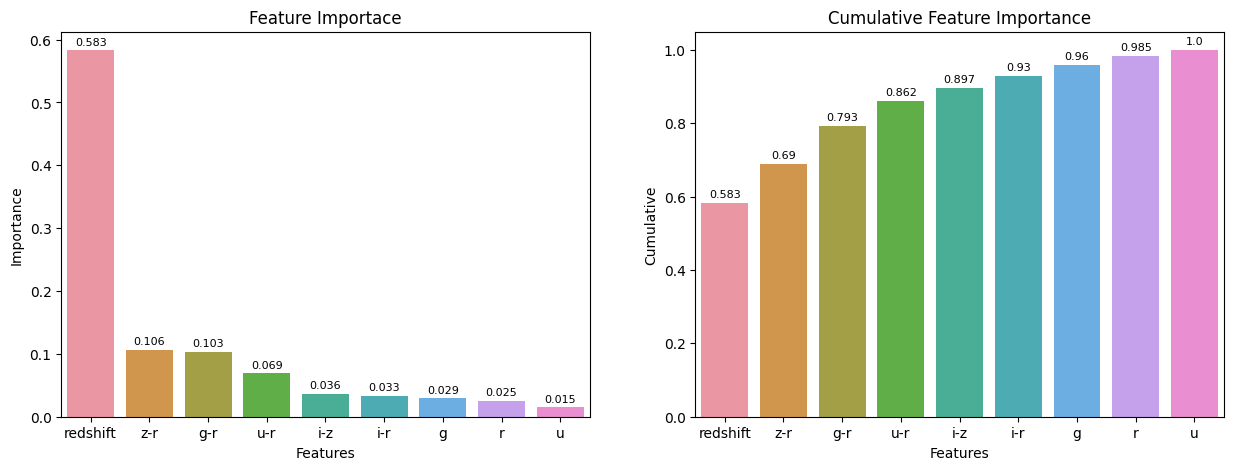

Train
Logloss: 0.023
Best parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'log_loss'}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


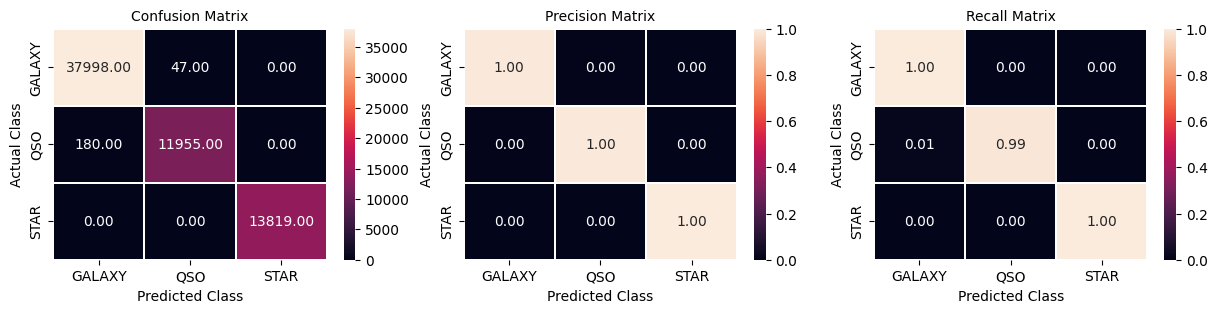

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     38045
         QSO       1.00      0.99      0.99     12135
        STAR       1.00      1.00      1.00     13819

    accuracy                           1.00     63999
   macro avg       1.00      0.99      1.00     63999
weighted avg       1.00      1.00      1.00     63999

Cross Validation
Logloss: 0.071
Best parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'log_loss'}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


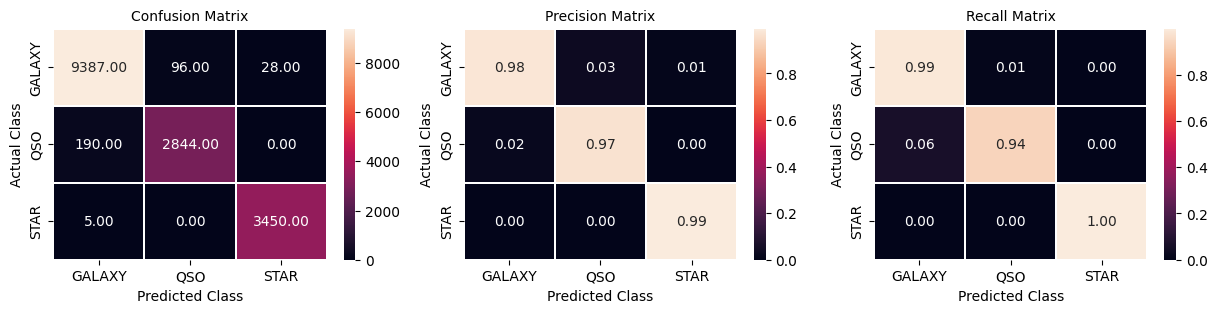

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98      9511
         QSO       0.97      0.94      0.95      3034
        STAR       0.99      1.00      1.00      3455

    accuracy                           0.98     16000
   macro avg       0.98      0.97      0.98     16000
weighted avg       0.98      0.98      0.98     16000

Test
Logloss: 0.083
Best parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': 100, 'criterion': 'log_loss'}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


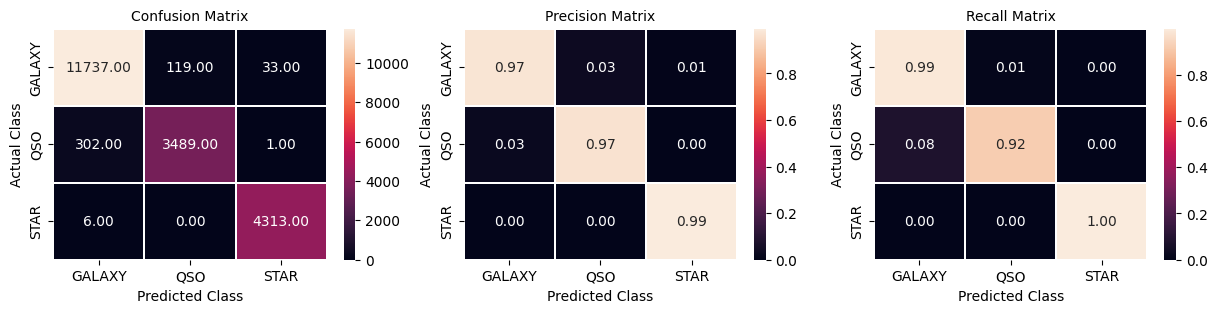

              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     11889
         QSO       0.97      0.92      0.94      3792
        STAR       0.99      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



In [39]:
model_name = 'model_random_forest_classifier.pkl'

dist = dict(n_estimators=[5, 10, 25, 50, 100, 200, 250, 500, 1000],
            criterion=['gini', 'entropy', 'log_loss'],
            max_depth=[1, 5, 10, 25, 50, 100, 150],
            min_samples_split=[1, 5, 10, 25, 50, 100, 250, 500])

(rf_best,
 rf_tr_loss,
 rf_cv_loss,
 rf_te_loss) = random_forest_classifier(X_train=X_train,
                                        y_train=y_train,
                                        X_cv=X_cv,
                                        y_cv=y_cv,
                                        X_test=X_test,
                                        y_test=y_test,
                                        dist=dist,
                                        model_name=model_name,
                                        plot_fi=True)

4.2.6.1. Selecting important features using random forests

From feature importance plot from the above cell, I am taking features that contribute atmost $96\%$ of importance. The features that contribute $96\%$ of importance are - _g_, _redshift_, _g-r_, _i-z_, _u-r_, _i-r_, _z-r_.

In [40]:
fi_cols = ['g', 'redshift', 'g-r', 'i-z', 'u-r', 'i-r', 'z-r']

In [41]:
fi_tr_data = tr_fea_df[fi_cols]
fi_cv_data = cv_fea_df[fi_cols]
fi_te_data = te_fea_df[fi_cols]

In [42]:
def export_data(data, target_arr, filename):
    """
    This function exports the data.
    
    Parameters
    ----------
    `data`: dataframe
    `filename`: the filename that data will be exported to
    """
    if os.path.isdir('./data/fi_data'):
        pass
    else:
        os.mkdir(path='./data/fi_data')
    
    data['class'] = target_arr
    data.to_csv(path_or_buf=os.path.join('./data/fi_data', filename), index=None)
    print("The data is exported to '{}'.".format(filename))

In [43]:
export_data(data=fi_tr_data, target_arr=y_train, filename='fi_tr_data.csv')

The data is exported to 'fi_tr_data.csv'.


In [44]:
export_data(data=fi_cv_data, target_arr=y_cv, filename='fi_cv_data.csv')

The data is exported to 'fi_cv_data.csv'.


In [45]:
export_data(data=fi_te_data, target_arr=y_test, filename='fi_te_data.csv')

The data is exported to 'fi_te_data.csv'.


4.2.7. XGBoost classifier

In [46]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [47]:
def encode_targets(y_train, y_cv, y_test, labels):
    """
    This function encodes the targets.
    
    Parameters
    ----------
    `y_train`: targets in train set
    `y_cv`: targets in cross validation set
    `y_test`: targets in test set
    `labels`: target values
    
    Returns a tuple of encoded target sets.
    """
    encoder = LabelEncoder()
    
    y_train = encoder.fit_transform(y=y_train)
    y_cv = encoder.transform(y=y_cv)
    y_test = encoder.transform(y=y_test)
    
    labels = encoder.transform(y=labels)
    
    return y_train, y_cv, y_test, labels

In [48]:
def xgb_classifier(X_train,
                   y_train,
                   X_cv,
                   y_cv,
                   X_test,
                   y_test,
                   dist,
                   model_name,
                   labels=labels):
    """
    This function builds the xgb classifier.
    """
    model_path = get_model_path(model_name=model_name)
    
    (y_train, y_cv,
     y_test, labels) = encode_targets(y_train=y_train, y_cv=y_cv,
                                      y_test=y_test, labels=labels)

    if not os.path.isfile(path=model_path):
        clf = XGBClassifier(n_jobs=-1, random_state=42)

        best = tuner(clf=clf, dist=dist, X=X_train, y=y_train)

        clf = XGBClassifier(n_estimators=best['n_estimators'],
                            max_depth=best['max_depth'],
                            n_jobs=-1, random_state=42)
        clf.fit(X=X_train, y=y_train)

        sig_clf = CalibratedClassifierCV(base_estimator=clf)
        sig_clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=(clf, sig_clf, best), file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf, sig_clf, best = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=sig_clf, X=X_train, y=y_train,
                       title='Train', best=best, labels=labels)
    cv_loss = reporter(clf=sig_clf, X=X_cv, y=y_cv,
                       title='Cross Validation', best=best, labels=labels)
    te_loss = reporter(clf=sig_clf, X=X_test, y=y_test,
                       title='Test', best=best, labels=labels)
    
    return best, tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 0.022
Best parameters: {'n_estimators': 200, 'max_depth': 25}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


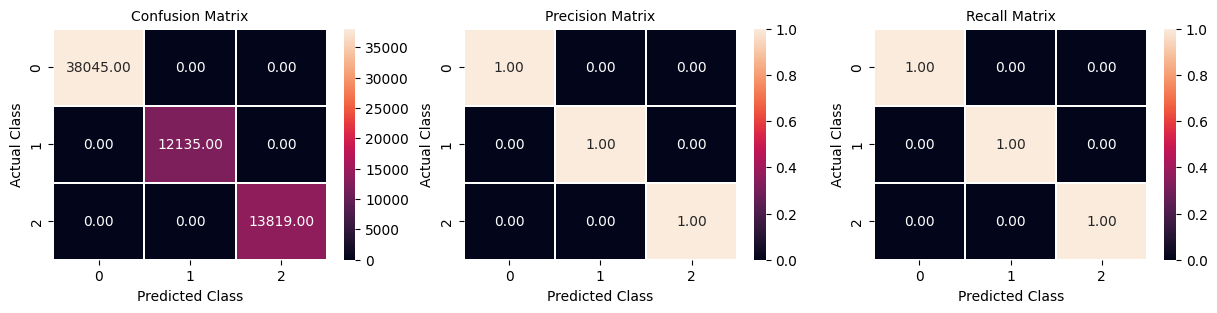

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38045
           1       1.00      1.00      1.00     12135
           2       1.00      1.00      1.00     13819

    accuracy                           1.00     63999
   macro avg       1.00      1.00      1.00     63999
weighted avg       1.00      1.00      1.00     63999

Cross Validation
Logloss: 0.081
Best parameters: {'n_estimators': 200, 'max_depth': 25}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


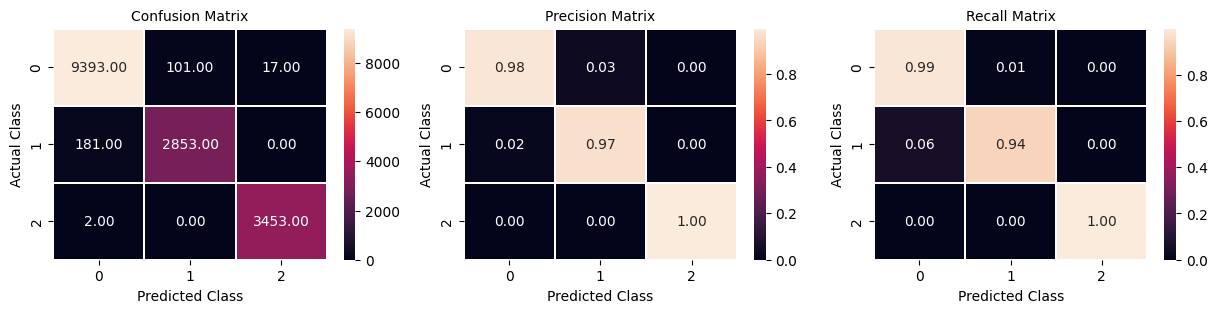

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9511
           1       0.97      0.94      0.95      3034
           2       1.00      1.00      1.00      3455

    accuracy                           0.98     16000
   macro avg       0.98      0.98      0.98     16000
weighted avg       0.98      0.98      0.98     16000

Test
Logloss: 0.094
Best parameters: {'n_estimators': 200, 'max_depth': 25}
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


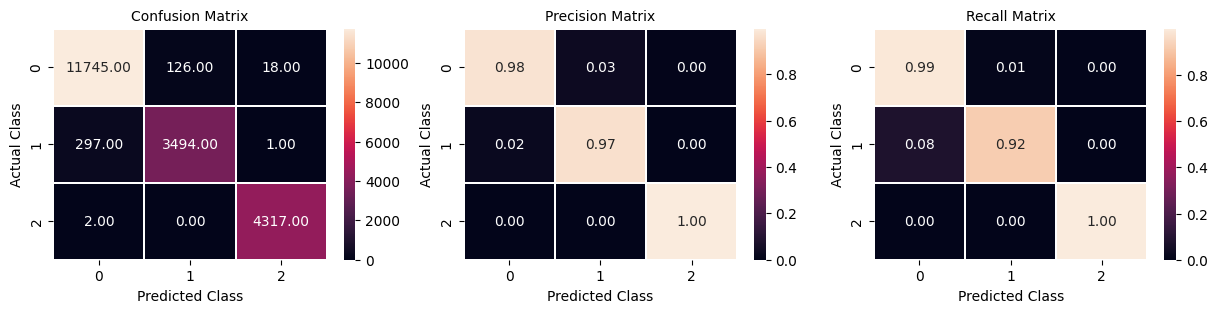

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11889
           1       0.97      0.92      0.94      3792
           2       1.00      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



In [49]:
model_name = 'model_xgb_classifier.pkl'

dist = dict(n_estimators=[5, 10, 25, 50, 100, 200, 250, 500, 1000],
            max_depth=[1, 5, 10, 25, 50, 100, 150])

(xgbc_best,
 xgbc_tr_loss,
 xgbc_cv_loss,
 xgbc_te_loss) = xgb_classifier(X_train=X_train,
                                y_train=y_train,
                                X_cv=X_cv,
                                y_cv=y_cv,
                                X_test=X_test,
                                y_test=y_test,
                                dist=dist,
                                model_name=model_name)

4.2.8. Stacking classifier

Reference: [https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)

In [50]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [51]:
def evaluate_model(model, X, y):
    """
    Model evaluation for base learners in stacking classifier.
    
    Parameters
    ----------
    `model`: estimator
    `X`: features
    `y`: targets
    
    Returns cross validation scores.
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(estimator=model,
                             X=X, y=y, scoring='accuracy',
                             cv=cv, n_jobs=-1,
                             error_score='raise')
    return scores

In [52]:
def stacking_classifier(X_train,
                        y_train,
                        X_cv,
                        y_cv,
                        X_test,
                        y_test,
                        models,
                        model_name,
                        labels=labels):
    """
    This function builds the stacking classifier.
    """
    model_path = get_model_path(model_name=model_name)
    
    if not os.path.isfile(path=model_path):
        clf = StackingClassifier(estimators=models)
        clf.fit(X=X_train, y=y_train)

        with open(file=model_path, mode='wb') as m_pkl:
            pickle.dump(obj=clf, file=m_pkl)
        print("Model saved into the disk.\n")
    else:
        with open(file=model_path, mode='rb') as m_pkl:
            clf = pickle.load(file=m_pkl)
        print("Loaded the saved model from the disk.\n")
    
    tr_loss = reporter(clf=clf, X=X_train, y=y_train,
                       title='Train', labels=labels)
    cv_loss = reporter(clf=clf, X=X_cv, y=y_cv,
                       title='Cross Validation', labels=labels)
    te_loss = reporter(clf=clf, X=X_test, y=y_test,
                       title='Test', labels=labels)
    
    return tr_loss, cv_loss, te_loss

Loaded the saved model from the disk.

Train
Logloss: 0.058
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


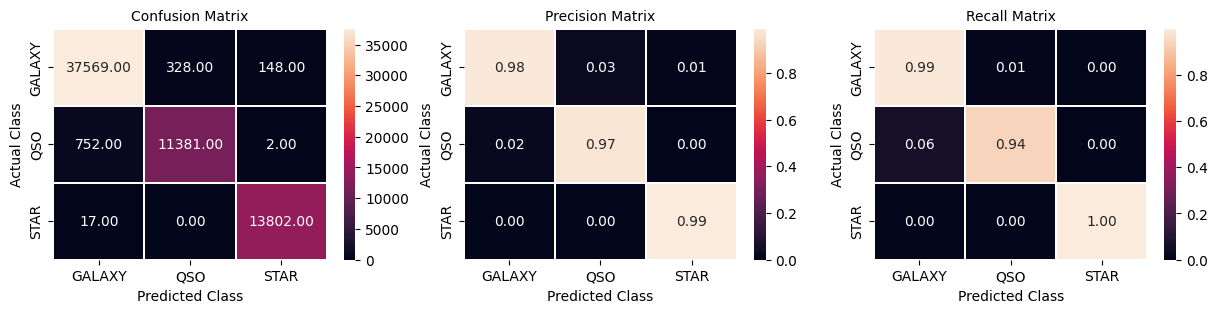

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     38045
         QSO       0.97      0.94      0.95     12135
        STAR       0.99      1.00      0.99     13819

    accuracy                           0.98     63999
   macro avg       0.98      0.97      0.98     63999
weighted avg       0.98      0.98      0.98     63999

Cross Validation
Logloss: 0.078
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


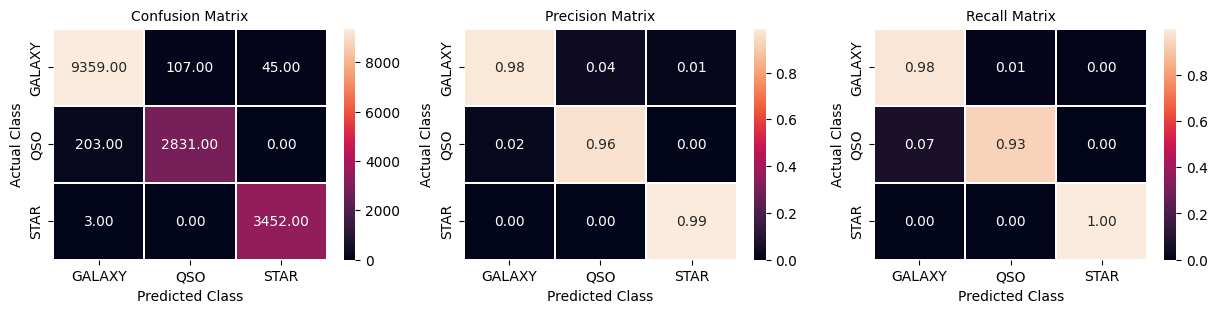

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      9511
         QSO       0.96      0.93      0.95      3034
        STAR       0.99      1.00      0.99      3455

    accuracy                           0.98     16000
   macro avg       0.98      0.97      0.97     16000
weighted avg       0.98      0.98      0.98     16000

Test
Logloss: 0.089
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


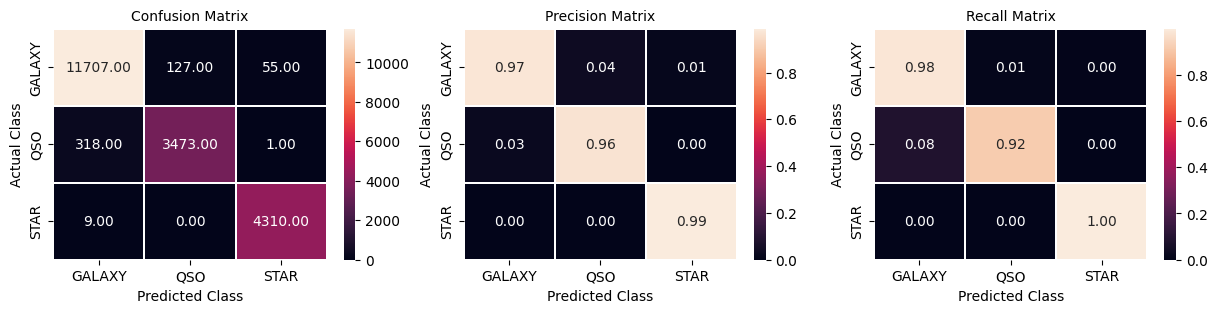

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     11889
         QSO       0.96      0.92      0.94      3792
        STAR       0.99      1.00      0.99      4319

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [53]:
model_name = 'model_stacking_classifier.pkl'

LR = LogisticRegression(penalty=logreg_best['penalty'],
                        C=logreg_best['C'],
                        class_weight='balanced',
                        random_state=42,
                        n_jobs=-1, max_iter=1000)

SV = SVC(C=svc_best['C'], random_state=42, class_weight='balanced')

KNN = KNeighborsClassifier(n_neighbors=knn_best['n_neighbors'], n_jobs=-1)

DT = DecisionTreeClassifier(criterion=dt_best['criterion'],
                            max_depth=dt_best['max_depth'],
                            min_samples_split=dt_best['min_samples_split'],
                            random_state=42)

models = [('LR', LR), ('SVC', SV), ('KNN', KNN), ('DT', DT)]

(stack_tr_loss,
 stack_cv_loss,
 stack_te_loss) = stacking_classifier(X_train=X_train,
                                      y_train=y_train,
                                      X_cv=X_cv,
                                      y_cv=y_cv,
                                      X_test=X_test,
                                      y_test=y_test,
                                      models=models,
                                      model_name=model_name)

__5. Summary__

+----+---------------------+--------------+-----------+-------------+
|    | Models              |   Train Loss |   CV Loss |   Test Loss |
|----+---------------------+--------------+-----------+-------------|
|  0 | Dummy               |        1.099 |     1.099 |       1.099 |
|  1 | Logistic Regression |        0.322 |     0.32  |       0.324 |
|  2 | Support Vector      |        0.137 |     0.134 |       0.146 |
|  3 | K-Nearest Neighbors |        0.096 |     0.126 |       0.145 |
|  4 | Decision Tree       |        0.064 |     0.084 |       0.094 |
|  5 | Random Forest       |        0.023 |     0.071 |       0.083 |
|  6 | XGBoost             |        0.022 |     0.081 |       0.094 |
|  7 | Stacking            |        0.058 |     0.078 |       0.089 |
+----+---------------------+--------------+-----------+-------------+


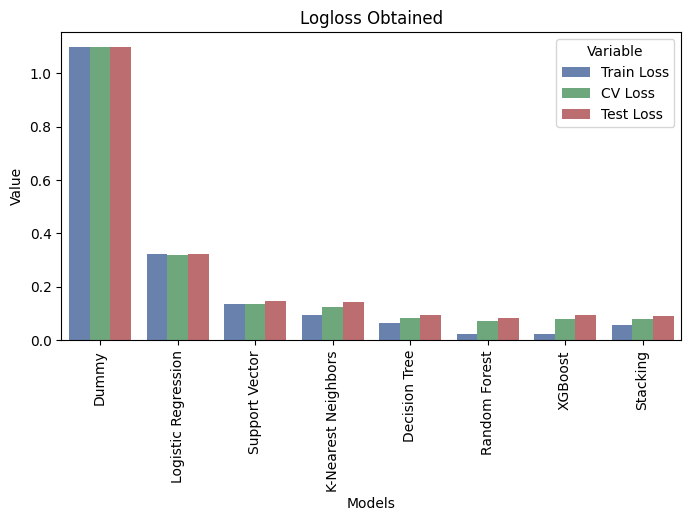

In [54]:
model_names = ['Dummy', 'Logistic Regression', 'Support Vector',
               'K-Nearest Neighbors', 'Decision Tree',
               'Random Forest', 'XGBoost', 'Stacking']

tr_losses = [dummy_tr_loss, logreg_tr_loss, svc_tr_loss, knn_tr_loss,
             dt_tr_loss, rf_tr_loss, xgbc_tr_loss, stack_tr_loss]
cv_losses = [dummy_cv_loss, logreg_cv_loss, svc_cv_loss, knn_cv_loss,
             dt_cv_loss, rf_cv_loss, xgbc_cv_loss, stack_cv_loss]
te_losses = [dummy_te_loss, logreg_te_loss, svc_te_loss, knn_te_loss,
             dt_te_loss, rf_te_loss, xgbc_te_loss, stack_te_loss]

summary_df = pd.DataFrame()
summary_df['Models'] = model_names
summary_df['Train Loss'] = tr_losses
summary_df['CV Loss'] = cv_losses
summary_df['Test Loss'] = te_losses

summary = tabulate(tabular_data=summary_df, headers='keys',
                   tablefmt='psql')
print(summary)

tidy = summary_df.melt(id_vars='Models').rename(columns=str.title)

plt.figure(figsize=(8, 4))
sns.barplot(data=tidy, x='Models', y='Value', hue='Variable', alpha=0.9)
plt.title(label='Logloss Obtained')
plt.xticks(rotation=90)
plt.show()

__6. Conclusion__

1. Logistic Regression, K-Nearest Neighbors, Support Vector, and Decision Tree models/classifiers do not show much signs of extreme overfitting.
2. Random Forest and XGBoost models are showing signs of extreme overfitting.
3. Logistic Regression, K-Nearest Neighbors, Support Vector, and Decision Tree models/classifiers are stacked into one model using Stacking Classifer. The performance is better compared to Random Forest and XGBoost classifiers.